In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from torch import optim
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

In [19]:
class ExpandedCnnLSTM(nn.Module):
  
  def __init__(self, resnet_model, n_channels, output_size, hidden_dim, n_lstm_layers, drop_prob=0.5, debug=False):

    super(ExpandedCnnLSTM, self).__init__()

    self.output_size = output_size
    self.n_lstm_layers = n_lstm_layers
    self.hidden_dim = hidden_dim
    self.n_channels = n_channels
          
    model = torch.hub.load('pytorch/vision:v0.6.0', resnet_model, pretrained=True)
    out_channels = model.conv1.in_channels
    kernel_size = model.conv1.kernel_size
    stride = model.conv1.stride
    padding = model.conv1.padding
    self.convPadd = nn.Conv2d(n_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    
    self.embeding_dim = model.fc.in_features
    self.cnn = torch.nn.Sequential(*(list(model.children())[:-1]))
    if debug:
      print(model.eval())
      print(self.cnn[0].in_channels)
    

    self.lstm = nn.LSTM(self.embeding_dim, hidden_dim, n_lstm_layers, dropout=drop_prob, batch_first=True)
    self.dropout = nn.Dropout(drop_prob)
    self.fc = nn.Linear(hidden_dim, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):

    batch_size = x.size(0)
    n_frames = x.size(1)

    features = torch.zeros((batch_size, n_frames, self.embeding_dim))

    for i in range(n_frames):
      padded = self.convPadd(x[:,i,:])
      features[:,i,:] = self.cnn(padded).squeeze()

    lstm_out, hidden = self.lstm(features.to(device))
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
    out = self.dropout(lstm_out)
    out = self.fc(out)
    out = self.sigmoid(out)
    
    out = out.view(batch_size, -1)
    out = out[:,-1]
    
    return out

  def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_lstm_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_lstm_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [20]:
#cl_model = CnnLSTM(4, 1, 512, 2)
cl_model = ExpandedCnnLSTM('resnet18', 4, 1, 512, 2, debug=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
#input_image = Image.open(filename)
#preprocess = transforms.Compose([
#    transforms.Resize(256),
#    transforms.CenterCrop(224),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#])
#input_tensor = preprocess(input_image)
#input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

test_batch = torch.randn((6, 13, 4, 256, 256))
hidden = cl_model.init_hidden(test_batch.size(0))
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    test_batch.cuda()
    cl_model.cuda()
    device = 'cuda'

with torch.no_grad():
    output = cl_model(test_batch.cuda())
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

tensor(0.4925, device='cuda:0')
tensor(1., device='cuda:0')


In [22]:
train_dummy_data = np.ones((50, 5, 4, 256, 256))
train_dummy_data = np.append(train_dummy_data, np.zeros_like(train_dummy_data), axis=0)

print(train_dummy_data.shape)

train_dummy_labels = np.ones((50))
train_dummy_labels = np.append(train_dummy_labels, np.zeros_like(train_dummy_labels))

print(train_dummy_labels.shape)

(100, 5, 4, 256, 256)
(100,)


In [23]:
val_dummy_data = np.ones((10, 5, 4, 256, 256))
val_dummy_data = np.append(val_dummy_data, np.zeros_like(val_dummy_data), axis=0)

print(val_dummy_data.shape)

val_dummy_labels = np.ones((10))
val_dummy_labels = np.append(val_dummy_labels, np.zeros_like(val_dummy_labels))

print(val_dummy_labels.shape)

(20, 5, 4, 256, 256)
(20,)


In [24]:
test_dummy_data = np.ones((10, 5, 4, 256, 256))
test_dummy_data = np.append(test_dummy_data, np.zeros_like(test_dummy_data), axis=0)

print(test_dummy_data.shape)

test_dummy_labels = np.ones((10))
test_dummy_labels = np.append(test_dummy_labels, np.zeros_like(test_dummy_labels))

print(test_dummy_labels.shape)

(20, 5, 4, 256, 256)
(20,)


In [25]:
class LanslideDataset(Dataset):
  
    def __init__(self, data, y):

        self.data = data 
        self.y = y.reshape(len(y))

        #print(len(self.data))
        #print(len(self.y))
        assert len(self.y) == len(self.data)


    def __len__(self): 
        return len(self.y)   

    def __getitem__(self, idx):
        return [self.data[idx], self.y[idx]]

In [26]:
train_ds = LanslideDataset(train_dummy_data, train_dummy_labels)
val_ds = LanslideDataset(val_dummy_data, val_dummy_labels)

In [27]:
print('GPU disponible:' , torch.cuda.is_available())

GPU disponible: True


In [128]:
class TrainModule():
  
  def __init__(self, model, opt, loss_func, save_path = ""):
    #self.params = params
    self.model = model
    self.opt = opt
    self.loss_func = loss_func

    self.fig = plt.figure(figsize=(15, 7))
    self.ax0 = self.fig.add_subplot(1, 2, 1) 
    self.ax1 = self.fig.add_subplot(1, 2, 2)
    
    self.save_path = save_path

    self.save_period = 100

    self.visualize_period = 5

  def get_data(self, train_ds, valid_ds, bs, n_cores):

    self.bs = bs

    self.train_dl =  DataLoader(train_ds,
                          batch_size=bs,
                          shuffle=True,
                          num_workers=n_cores)
        
    self.val_dl =  DataLoader(valid_ds,
                          batch_size=bs * 2,
                          num_workers=n_cores)
    
  def set_optimizer(self, opt):
    self.opt = opt

  def set_loss_func(self, loss_func):
    self.loss_func = loss_func
  
  def loss_batch(self, model, loss_func, xb, yb, opt=None):
    y_hat = model(xb)
    loss = loss_func(y_hat, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #accu = self.accuracy(y_hat, yb)

    return loss.item(), len(xb) #, accu

  def accuracy(self, y_hat_b,yb):
    
    preds = torch.argmax(torch.softmax(y_hat_b.view(-1), dim = 1),dim=1)
    counts = (preds == yb)*1.0
    
    return torch.mean(counts)

  def bin_accuracy(self, y_hat_b,yb):
    
    count = (yb == (y_hat_b > 0.5))*1.0
    return torch.mean(count)

  def register(self, res_list):
    
    losses, nums = zip(*res_list)
    
    N = np.sum(nums)
    loss_mean = np.sum(np.multiply(losses, nums))/N
    loss_std = np.sqrt(np.sum(np.multiply((losses-loss_mean)**2, nums))/(N-1))
    
    return loss_mean, loss_std

  #def early_stoping(self, learning_data):

  def plot_curves(self, loss_data, metric_data, epoch):
      yt = loss_data['train_mean']
      yv = loss_data['val_mean']
      x = np.arange(0, len(yt), 1)
      self.ax0.cla()
      self.ax0.plot(x, yt, label='train loss')
      self.ax0.plot(x, yv, label='val loss')
      self.ax0.legend(loc="upper right")
      self.ax0.set_title("Loss at epoch: {}".format(epoch))

      ytm = metric_data['train_mean']
      yvm = metric_data['val_mean']
      xm = np.arange(0, len(yt), 1)
      self.ax1.cla()
      self.ax1.plot(xm, ytm, label='train accu')
      self.ax1.plot(xm, yvm, label='val accu')
      self.ax1.legend(loc="lower right")
      self.ax1.set_title("Accuracy at epoch: {}".format(epoch))

      display(self.fig)
      
      clear_output(wait = True)
    
  def load_learning_data(self, learning_data):

    self.learning_data = learning_data

  def save_checkpoint(self, model, optimizer, loss_data, metric_data,  epoch):

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            'loss_data': loss_data,
            'metric_data': metric_data
            }, self.save_path + "checkpoint_" + str(epoch))
    
  def load_model(self, model, path):

    model = torch.load(path)

    return model
    
  def save_best_model(self, model, optimizer, loss_data, metric_data, epoch):

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            'loss_data': loss_data,
            'metric_data': metric_data
            }, self.save_path + "best_model")
    
  def load_checkpoint(self, path):

      checkpoint = torch.load(path)
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      epoch = checkpoint['epoch']
      loss_data = checkpoint['loss_data']
      metric_data = checkpoint['metric_data']

      self.loss_data = loss_data
      self.metric_data = metric_data

      return epoch, loss_data, metric_data


  def fit(self, 
        epochs,
        metric=None,
        only_print=False,
        print_leap = 1):
    
    print('GPU disponible:' , torch.cuda.is_available())
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    print("Using ", device)

    self.model.to(device)
    self.model = self.model.float()

    if metric is None:
        #metric = self.accuracy
        metric= self.bin_accuracy
        #metric = self.loss_func

    loss_data = pd.DataFrame(
        columns=['epoch', 'train_mean', 'train_std', 'val_mean', 'val_std'])
    
    metric_data = pd.DataFrame(
        columns=['epoch', 'train_mean', 'train_std', 'val_mean', 'val_std'])
    
    best_val_loss = np.inf

    for epoch in tqdm(range(epochs)):

        # Entrenamiento -------------------------------------------------------
        train_res = []
        train_metric = []
        self.model.train()
        for xb, yb in self.train_dl:
            # Actualizacion de parametros
            xb, yb = xb.to(device), yb.to(device)
            self.opt.zero_grad()
            self.loss_batch(self.model, self.loss_func, xb.float(), yb.float(), self.opt)

            # Evaluacion en entrenamiento
            with torch.no_grad():
              train_res.append(self.loss_batch(self.model, self.loss_func, xb.float(), yb.float()))
              train_metric.append(self.loss_batch(self.model, metric, xb.float(), yb.float()))

        # Validacion ----------------------------------------------------------
        # Para evaluar se puede utilizar un metrica de rendimiento
        self.model.eval()

        with torch.no_grad():
            val_res = [
                self.loss_batch(self.model, self.loss_func, xb.to(device).float(), yb.to(device).float()) for xb, yb in self.val_dl]
            val_metric = [
                self.loss_batch(self.model, metric, xb.to(device).float(), yb.to(device).float()) for xb, yb in self.val_dl]

        
        val_loss0, val_std0 = self.register(val_res)
        tra_loss0, train_std0 = self.register(train_res)
        
        
        #if epoch % print_leap == 0:
        #    print('Epoca:', epoch, '- val:', val_loss, '- train:', tra_loss)

        loss_data = loss_data.append(
            {
                'epoch': epoch,
                'train_mean': tra_loss0,
                'train_std': train_std0,
                'val_mean': val_loss0,
                'val_std': val_std0
            },
            ignore_index=True)
        
        val_loss1, val_std1 = self.register(val_metric)
        tra_loss1, train_std1 = self.register(train_metric)
        
        metric_data = metric_data.append(
            {
                'epoch': epoch,
                'train_mean': tra_loss1,
                'train_std': train_std1,
                'val_mean': val_loss1,
                'val_std': val_std1
            },
            ignore_index=True)
        

        if (epoch + 1) % self.save_period == 0:
            #print("saving checkpoint at epoch ", epoch)
            self.save_checkpoint(self.model, self.opt, loss_data, metric_data, epoch)

        if epoch > epochs/10 and val_loss0 < best_val_loss:
            #print("saving best model at epoch ", epoch)
            self.save_best_model(self.model, self.opt, loss_data, metric_data, epoch)

        if epoch % self.visualize_period  == 0:
            self.plot_curves(loss_data, metric_data, epoch)

    if only_print:
        print('Proceso terminado')
    else:
        self.loss_data = loss_data
        self.metric_data = metric_data
        return loss_data, metric_data


In [129]:
cl_model = ExpandedCnnLSTM('resnet18', 4, 1, 512, 2, debug=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


(    epoch  train_mean  train_std  val_mean   val_std
 0     0.0    0.395721   0.940765  0.094992  0.062310
 1     1.0    0.251210   0.446380  0.015889  0.003288
 2     2.0    0.128793   0.227852  0.008157  0.004016
 3     3.0    0.172516   0.363266  0.021160  0.012688
 4     4.0    0.091623   0.183630  2.263346  1.984744
 5     5.0    0.004516   0.009522  3.015492  2.647891
 6     6.0    0.001596   0.000669  0.001152  0.000011
 7     7.0    0.001154   0.000519  3.622079  3.181725
 8     8.0    0.000886   0.000266  3.715695  3.264083
 9     9.0    0.000770   0.000285  3.697880  3.248488
 10   10.0    0.000556   0.000224  3.870090  3.399871
 11   11.0    0.000559   0.000206  3.689169  3.240964
 12   12.0    0.000490   0.000207  0.001293  0.000845
 13   13.0    0.000415   0.000152  4.043545  3.552387
 14   14.0    0.000320   0.000127  4.107994  3.609040
 15   15.0    0.000285   0.000107  4.194785  3.685335
 16   16.0    0.000267   0.000083  0.000190  0.000018
 17   17.0    0.000297   0.0

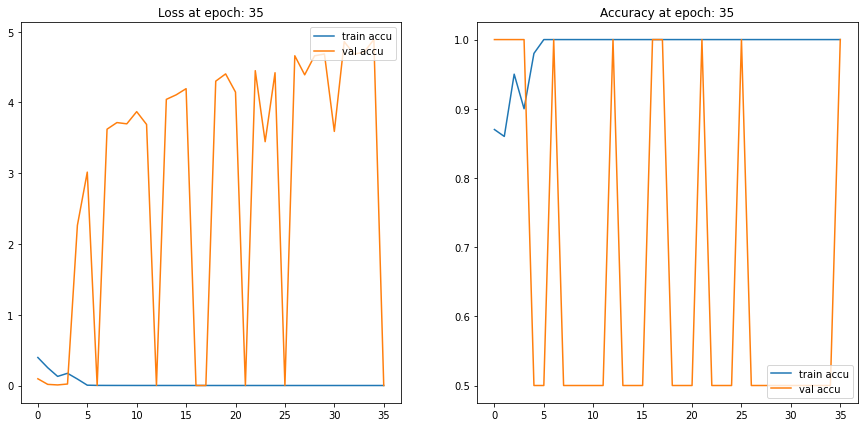

In [130]:
opt = optim.Adam(cl_model.parameters())

loss_func = torch.nn.BCELoss()

TM = TrainModule(cl_model, opt, loss_func)

TM.get_data(train_ds, val_ds, 3, 0)

TM.fit(40)